In [17]:
import sys 
sys.path.append('/Users/mcdermottspeakerarray/Documents/binaural_cocktail_party/SpeakerArray')
from src.utils import speaker_utils
import numpy as np
import pickle
import asyncio
from scipy.io import wavfile
import sounddevice as sd
import itertools 
from src.utils import speaker_utils

%matplotlib inline
import matplotlib.pyplot as plt

import librosa
from scipy.signal import find_peaks

import IPython.display as ipd

## To test 
(-90,-20)  and (-90,-10)

In [3]:
path = '/Users/mcdermottspeakerarray/Documents/binaural_cocktail_party/msjspsych-main/experiment_word_recognition/speaker_array_manifests/pilot_rel_dist_elev_v01/participant_001_pilot_trial_dict.pkl'
with open(path, 'rb') as f:
    trial_dict = pickle.load(f)

(2, 88200)

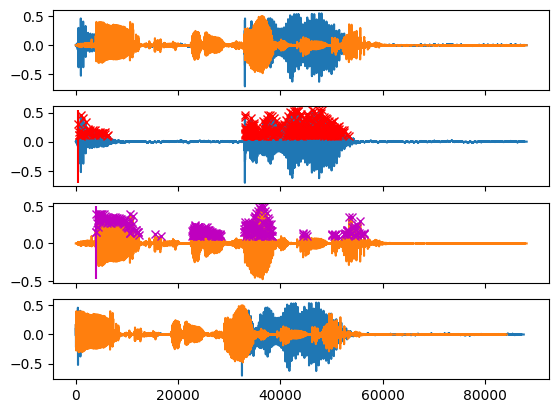

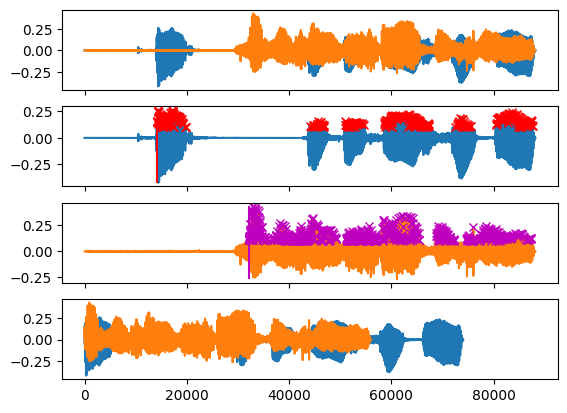

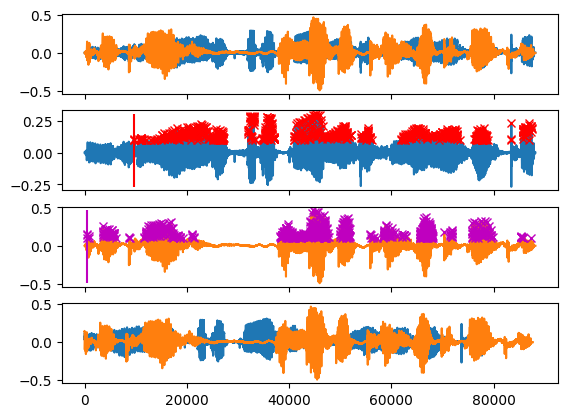

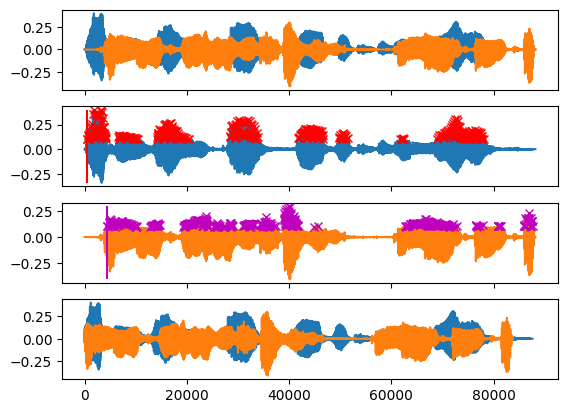

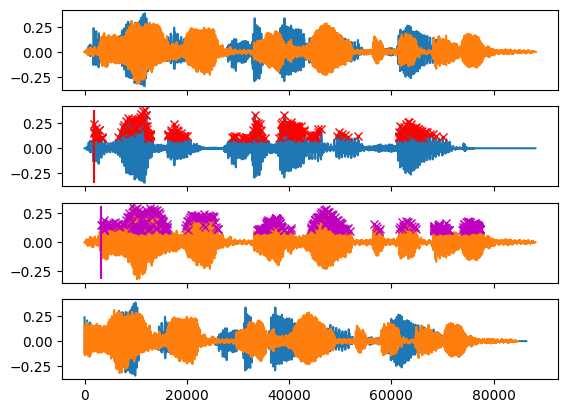

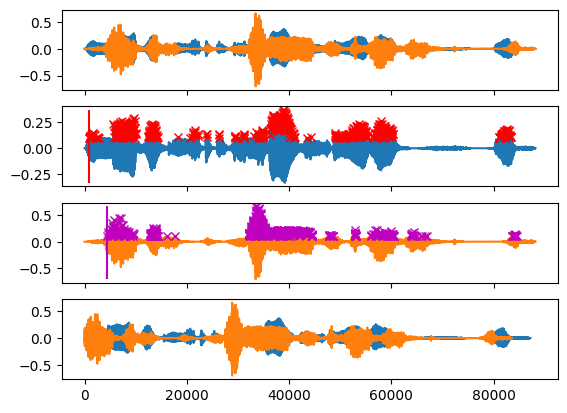

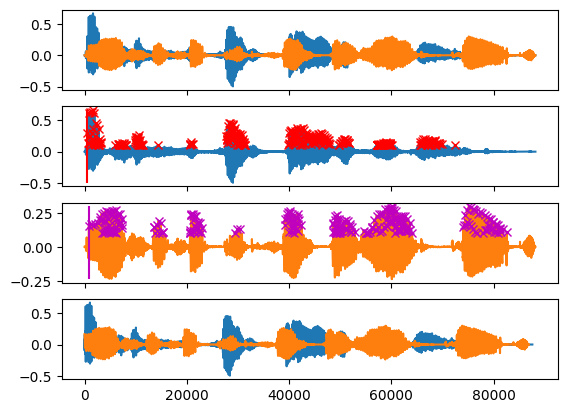

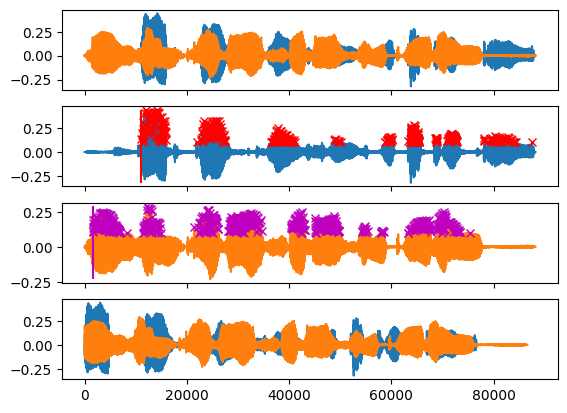

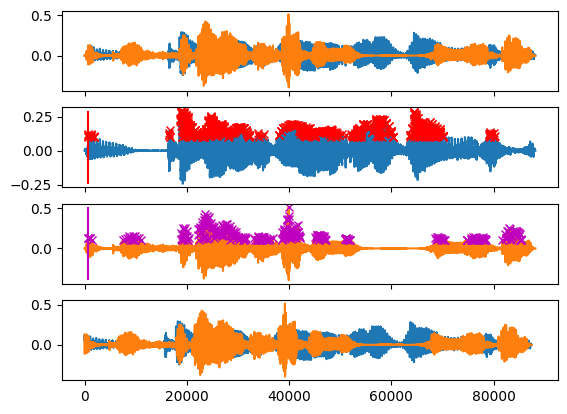

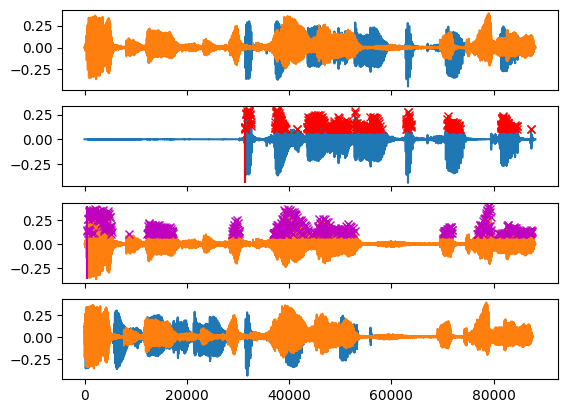

In [24]:
buffer_size = .025 # in s 
sr = 44100 
buffer_frames = int(buffer_size * sr ) 


for ix in range(10):
    trial = trial_dict[ix]
    _, trial_sounds = speaker_utils.read_all(trial[2:])
    trial_sounds = list(
        map(lambda s: speaker_utils.rms_norm(s, 65), trial_sounds)
    )
    trial_sounds = speaker_utils.pad_to_longest(*trial_sounds)
    stim_silence = np.zeros_like(trial_sounds[-1])
    cue_sound = trial_sounds[0]
    sound_one, sound_two = trial_sounds[1:]
    fig, axs = plt.subplots(4,1, sharex=True)
    # plot audio
    axs[0].plot(sound_one)
    axs[0].plot(sound_two)
    # get onsets for signal 1 
    peaks1, _ = find_peaks(sound_one, height=.1)
    axs[1].plot(sound_one)
    axs[1].plot(peaks1, sound_one[peaks1],'rx')
    axs[1].vlines(x=peaks1[0], ymin=sound_one.min(), ymax=sound_one.max(), color='r')
    # get onsets for signal 2
    peaks2, _ = find_peaks(sound_two, height=.1)
    axs[2].plot(sound_two, c='C1')
    axs[2].plot(peaks2, sound_two[peaks2],'mx')
    axs[2].vlines(x=peaks2[0], ymin=sound_two.min(), ymax=sound_two.max(), color='m')
    # align onsets 
    onset1 = peaks1[0]
    onset2 = peaks2[0]
    # if onset1 > buffer_frames:
        # print("shifting sound one")
    sound_one = sound_one[onset1:]
    # if onset2 > buffer_frames:
        # print("shifting sound two")
    sound_two = sound_two[onset2:]
    axs[3].plot(sound_one)
    axs[3].plot(sound_two)
    # mix sounds 
    mixture = np.zeros(int(2.2 * sr))
    mixture[: len(sound_one)] += sound_one
    mixture[: len(sound_two)] += sound_two
    # rms normalize to 60 (is 0.02 rms)
    mixture = mixture - np.mean(mixture)
    mix_rms = np.sqrt(np.mean(np.power(mixture, 2)))
    mixture = mixture * 0.02 / mix_rms 
    ipd.display(ipd.Audio(mixture, rate=44100, normalize=False))

    
    
    
    


In [48]:
## Double check rms normalization

def convert_dba_to_rms(dba: float) -> float:
    """
    Given a dB value at 2 meters (center of the array), convert it
    to a proper input value for the rms_norm function

    These values for the conversion were measured on 6/22/2022 in the
    array room as a line of best fit for a linear relationship with the
    function below by directly varying target_rms_db

    measured on volume 30 Dell xps 15 9050
    """
    #TODO: REMEMBER TO CHANGE THIS BACK
    # if dba > 70:
    #     raise ValueError("You cannot play a sound over 70 dB.")
    # return (dba - 86.37) / 1.8
    # [ 1.75834711, 86.01256198]
    return (dba - 86.01256198) / 1.75834711


def standard_rms_norm(wav, dba):
    # target_rms = 20e-6 * np.power(10.0, dba / 20.0)
    # print(target_rms)
    target_rms = convert_dba_to_rms(dba)
    target_rms = 10 ** (target_rms / 10.0)
    print(target_rms)
    wav = wav - wav.mean()
    rms_wav = np.sqrt(np.mean(np.power(wav,2)))
    print(rms_wav)
    wav = wav * target_rms / rms_wav 
    return wav 
    

def rms_norm(wav: np.ndarray, dba: float) -> np.ndarray:
    #TODO: FIX THIS NONSENSE 
    # Likely taken from this post:
    # https://superkogito.github.io/blog/2020/04/30/rms_normalization.html
    target_rms_db = convert_dba_to_rms(dba)
    print(target_rms_db)

    wav = wav - wav.mean()
    # target_rms should = 20e-6 * np.power(10.0, self.dbspl / 20.0)
    target_rms = 10 ** (target_rms_db / 10.0)
    print(target_rms)
    # should be sig * new_rms / rms_sig 
    a = np.sqrt((len(wav) * target_rms**2) / np.sum(wav**2))
    norm_wav = wav * a
    return norm_wav

In [49]:
su_norm = rms_norm(mixture, 60)
std_norm = standard_rms_norm(mixture, 60)

-14.793758201701142
0.03316073742875184
0.03316073742875184
0.02


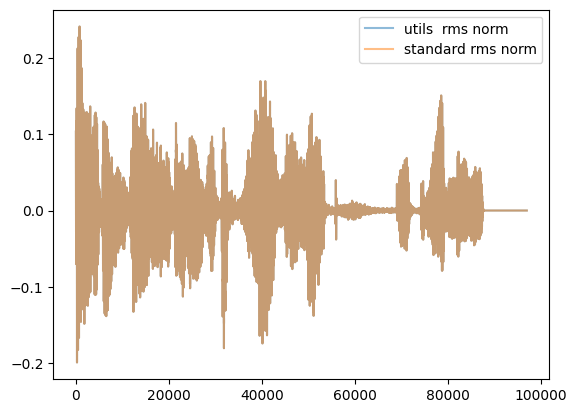

In [51]:
plt.plot(su_norm, alpha=0.5, label='utils  rms norm')
plt.plot(std_norm, alpha=0.5, label='standard rms norm')
plt.legend()
